In [1]:
import json
from pathlib import Path
from PIL import Image as PILImage

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm


from rhana.labeler.unet import RHEEDTensorImage, RHEEDTensorMask, rle_encode, rle_decode
from rhana.labeler.masker import UnetMasker
from rhana.io.kashiwa import find_raw_rheed
from rhana.pattern import Rheed, RheedMask
from rhana.tracker.iou import IOUTracker, regions2detections, IOUMaskTracker

In [2]:
rheeds = find_raw_rheed(Path("~/RHEED/data/RHEED").expanduser())

In [16]:
ls ../learner

UNet_May6_2021_fixed.pkl  UNet_May6_2021.pkl


In [3]:
path = "../learner/UNet_May6_2021_fixed.pkl"

In [4]:
masker = UnetMasker(path)

In [16]:
not_processed = [
    "IT020",
    "IT021",
    "IT022",
    "IT023",
    "IT024",
    "IT025",
    "IT027",
    "IT028",
    "IT029",
    "IT030"
]

In [17]:
failed = [
#     "IT022",
    "IT025",
#     "IT029",
]

In [5]:
index_df = pd.DataFrame(
    columns=[
        "image_path",
        "full_mask_spot",
        "full_mask_streak",
        "crop_args",
        "crop_path",
        "crop_mask_spot",
        "crop_mask_streak"]
)

In [6]:
root = Path("/home/aurora/RHEED/UNetMask_crop")

image = root/"image"
image.mkdir(exist_ok=True)
mask = root/"predicted_mask"
full_mask = root/"predicted_full_mask"
index = root/"index.csv"

offset = 60
window_width = 400
window_height = 200


(<Figure size 432x288 with 1 Axes>, <AxesSubplot:>)

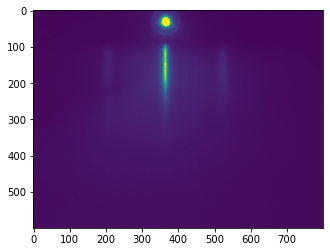

In [13]:
rd = Rheed.from_kashiwa(rheeds["IT027"][-20], log=False, use_mask=False)
rd.plot_pattern()

In [14]:
from rhana.spectrum import CollapseSpectrum

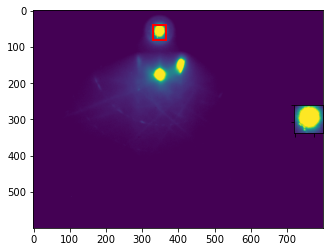

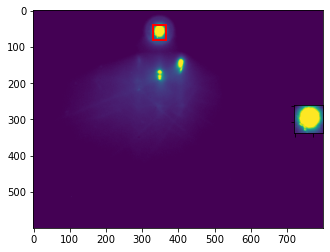

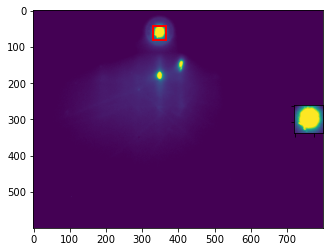

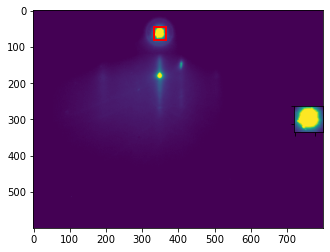

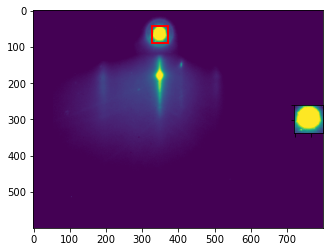

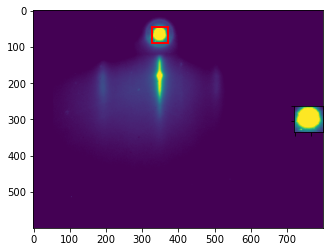

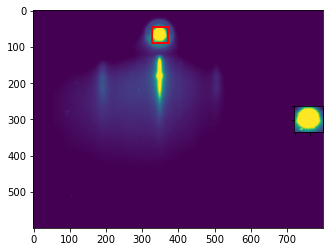

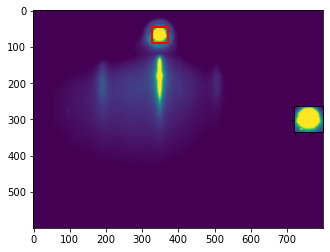

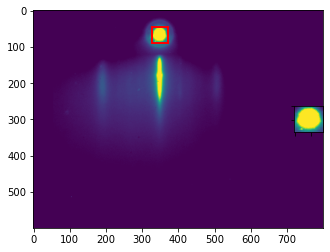

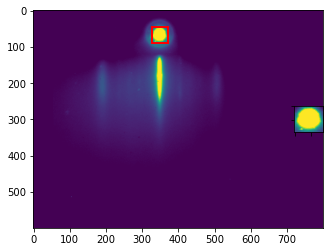

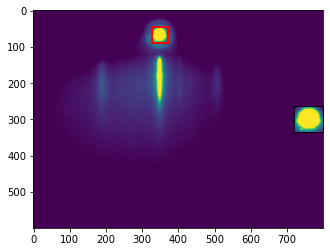

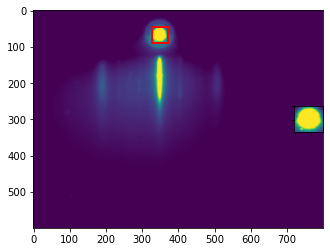

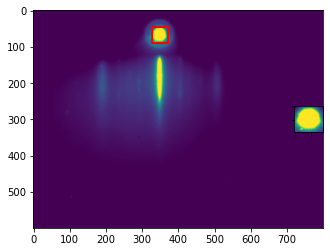

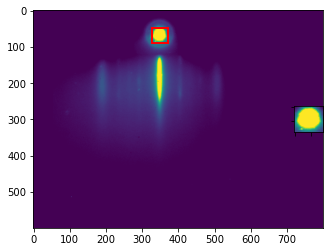

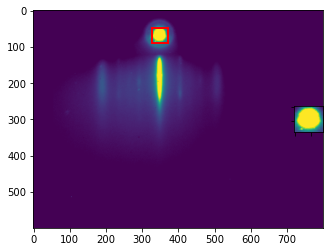

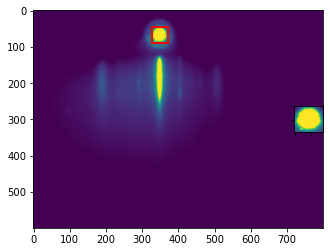

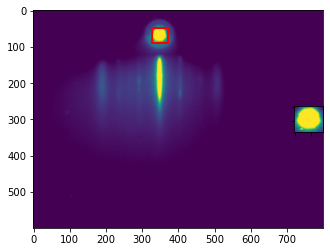

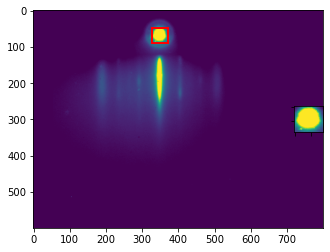

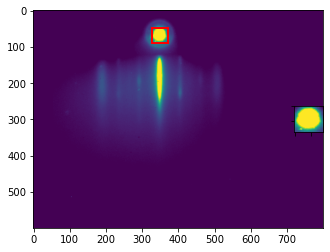

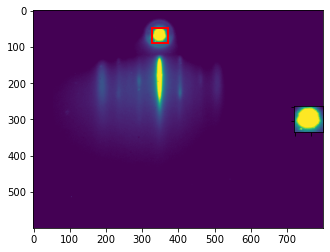

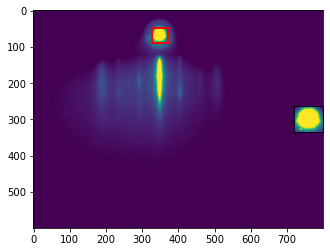

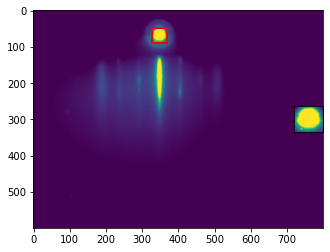

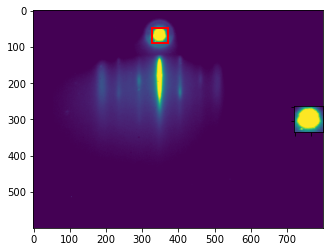

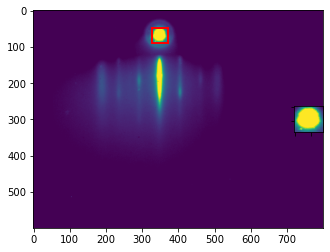

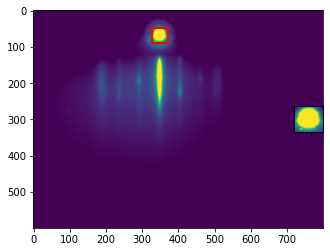

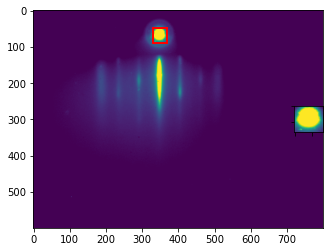

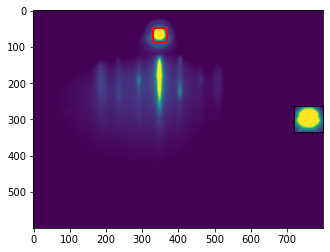

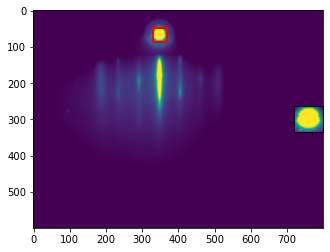

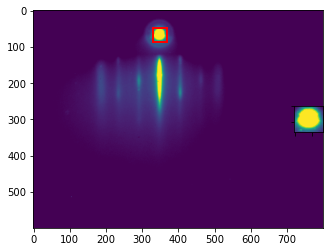

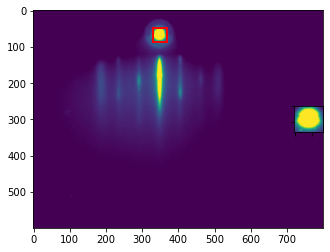

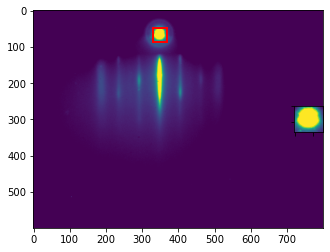

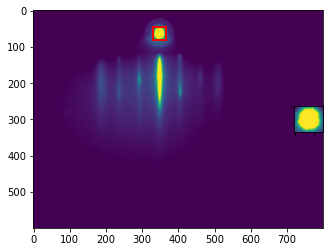

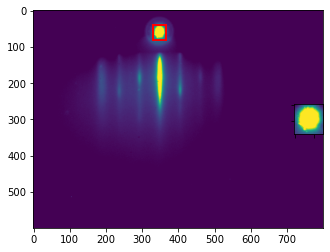

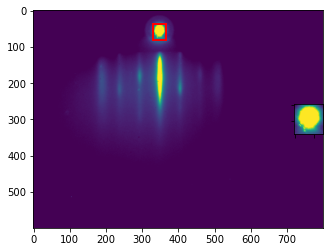

In [35]:
for IT in rheeds.keys():
# for IT in tqdm(failed, leave=False):
# for IT in tqdm(not_processed, leave=False):
# for IT in tqdm(["IT025"], leave=False):
    if len(rheeds[IT])==0: continue
    is_first = True
    lost_track = False
    
    raw_tracker = IOUMaskTracker(t_min=100000, sigma_iou=0.4)
    detail_tracker = IOUTracker(t_min=2, sigma_iou=0.4)
    
    for i, path in tqdm(enumerate(rheeds[IT]), total=len(rheeds[IT]), leave=False):
        
        # the first part track the direct beam and crop a window below it
        
        # get the mask using UNet 
        rd = Rheed.from_kashiwa(path)           
#         rd = Rheed.from_kashiwa(path, rotate=-0.7)     # for IT025
        rd = rd.mean_clip().min_max_scale()
        masks = masker.predict(rd)
        rdm_streak = RheedMask(rd, masks['streak'])
        rdm_spot = RheedMask(rd, masks['spot'])
        
        rdm_spot.get_regions(with_intensity=True)
        rdm_spot.filter_regions(min_area=10)

        # track the direct beam using IOU tracker
        region2tracks = raw_tracker.update(regions2detections(rdm_spot.regions), i)
        
        if is_first:
            # run blob detection and region detection in the same time
            # accept if all point to one region
            # pick the one with the biggest mask size if the region the blob point do not agree with the top region 
            db, db_i, track = rdm_spot.get_direct_beam(method="top+tracker", tracker=raw_tracker)
            db_r = rdm_spot.regions[db_i]
            
            rd.get_blobs()
            blob_db, blob_i= rd.get_direct_beam()
            
            blob_r, blob_ri= rdm_spot.get_region_within(x=blob_db[0], y=blob_db[1])
            if blob_ri != db_i and blob_r.area > db_r.area:
                db = blob_db
                db_i = blob_ri
                track = raw_tracker.region2track[blob_ri]
                
            is_first = False
                            
        else:
            try:
                # print("using tracking")
                db, db_i, track = rdm_spot.get_direct_beam(method="tracker", tracker=raw_tracker, track=track)
                if lost_track:
                    print("track is re-initiated by tracking")
                
                lost_track = False
            except KeyError as e:
                if not lost_track:
                    print(f"lost track at {path}")

                lost_track = True
                #
        if lost_track:            
            db_r, db_i = rdm_spot.get_region_within(*db)
            if db_r is not None:
                track = raw_tracker.region2track[db_i]
                print("track is re-initiated by locate a region that contain db point")
                lost_track = False
                
        # crop up a window that is always below the direct beam
        db = (round(db[0]), round(db[1]))

        sx = db[0] + offset
        sy = db[1] - window_width//2
        ex = db[0] + offset + window_height
        ey = db[1] + window_width//2

        cr_rdm_spot = rdm_spot.crop(sx=sx, sy=sy, ex=ex, ey=ey, inplace=False)
        cr_rdm_streak = rdm_streak.crop(sx=sx, sy=sy, ex=ex, ey=ey, inplace=False)

        # the second part would track only the croped area which would further stablize the tracking
        cr_rdm_spot.get_regions(with_intensity=True)
        cr_rdm_spot.filter_regions(min_area=10)

        # track the direct beam using IOU tracker
        region2tracks = detail_tracker.update(regions2detections(cr_rdm_spot.regions), i)
        
        # save the result
        
        # save crop image
        cr_im = PILImage.fromarray(np.uint8(cr_rdm_spot.rd.pattern*255))
        cr_path = image/IT/f"{path.stem}.png"
        cr_path.parent.mkdir(exist_ok=True)
        cr_im.save(cr_path)

        cr_masks = {"spot": cr_rdm_spot.mask, "streak": cr_rdm_streak.mask}
        
        cr_masks_rle = {k : rle_encode(v) for k, v in cr_masks.items()}
        masks_rle = {k : rle_encode(v) for k, v in masks.items()}

        cr_args = {
            "db_x":db[0],
            "db_y":db[1],
            "offset":offset,
            "window_width":window_width,
            "window_height":window_height,
            "cr_sx": sx,
            "cr_sy": sy,
            "cr_ex": ex,
            "cr_ey": ey,
        }

        record = {}
        record['image_path'] = str(path)
        record['full_mask_spot'] = masks_rle['spot']
        record['full_mask_streak'] = masks_rle['streak']
        record['crop_mask_spot'] = cr_masks_rle['spot']
        record['crop_mask_streak'] = cr_masks_rle['streak']

        record['crop_args'] = json.dumps(cr_args)
        record['crop_path'] = cr_path

        index_df = index_df.append(record, ignore_index=True)
        
        if i % 20 == 0:
        #    rdm_spot.plot_regions()
            rdm_spot.plot_region(db_i)
            plt.show()
        

(<Figure size 432x288 with 1 Axes>, <AxesSubplot:>)

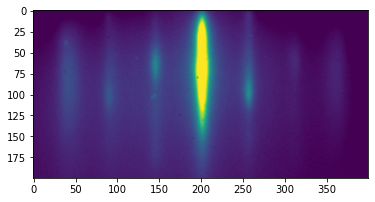

In [36]:
cr_rdm_spot.rd.plot_pattern()

In [21]:
!ls ../data/unet/*.csv

../data/unet/index.csv	../data/unet/index_old.csv


In [32]:
index_df.to_csv("../data/unet/index.csv")

In [23]:
# 

In [24]:
# plot the track's properties change (both raw and processed rheed)
# property: intensity, image moment?, center of gravity

# plot region with image in different time stamp
